# Create some plots for final model

In [1]:
# import libraries
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import seaborn as sns

### Prepare data

Import data and get lists of abn

In [2]:
# read in top variables
three_var_top_100 = pd.read_csv('../data/curated/final_model/output/3_varfinal_top100.csv')

five_var_top_100 = pd.read_csv('../data/curated/final_model/output/final_top100.csv')

In [3]:
three_var_top_100 = list(three_var_top_100['merchant_abn'])
five_var_top_100 = list(five_var_top_100['merchant_abn'])

In [4]:
# get different lists of merchants

three_var_only = list()
five_var_only = list()

intersection = list()

# only 3 var's top 100, not 5 var's top 100
for abn in three_var_top_100:
    if abn not in five_var_top_100:
        three_var_only.append(abn)

# only 5 var's top 100, not 3 var's top 100
for abn in five_var_top_100:
    if abn not in three_var_top_100:
        five_var_only.append(abn)

# only intersection of 3 var's top 100 and 5 var's top 100
for abn in five_var_top_100:
    if abn in three_var_top_100:
        intersection.append(abn)

In [5]:
# get complementary companies
merchant_overall = pd.read_csv('../data/curated/final_model/input/agg_fortnightly_mean_sd_marketcorr_NOFRAUD.csv')
five_var_complementary = [abn for abn in list(merchant_overall['merchant_abn']) if abn not in five_var_top_100]

In [6]:
# figure out how many is in intersection
print(len(five_var_only))
print(len(three_var_only))
print(len(intersection))

71
71
29


In [7]:
def get_data(abn_list, rhs_data):
    """ helper function to merge list with actual data for plots """
    return pd.DataFrame({'merchant_abn': abn_list}).merge(rhs_data, on = 'merchant_abn', how='inner')

Get clusters

In [8]:
merchant_clusters = pd.read_csv('../data/curated/clusters/output/merchant_clusters.csv')

In [9]:
# run through different lists to get data
five_vars_top_100_clusters = get_data(five_var_top_100, merchant_clusters)

three_vars_top_100_clusters = get_data(three_var_top_100, merchant_clusters)

intersection_clusters = get_data(intersection, merchant_clusters)

three_var_only_clusters = get_data(three_var_only, merchant_clusters)

five_var_only_clusters = get_data(five_var_only, merchant_clusters)

five_var_complementary_clusters = get_data(five_var_complementary, merchant_clusters)

Get training variables

(first create one final list of merchants)

*merchant overall already imported*

In [10]:
loyalty_overall = pd.read_csv(('../data/curated/final_model/input/loyalty_full.csv'))
loyalty_overall = loyalty_overall[['merchant_abn', 'repeated_purchase_rate']]

In [11]:
persona_overall = pd.read_csv(('../data/curated/final_model/input/persona_full.csv'))

In [12]:
# merge dataset with 4th variable
merchant_overall = merchant_overall.merge(loyalty_overall, on='merchant_abn', how='inner')
merchant_overall = merchant_overall.merge(persona_overall, on='merchant_abn', how='inner')

merchant_overall = merchant_overall.fillna(0)

In [13]:
merchant_overall['standardised stdev'] = merchant_overall['stdev']/merchant_overall['mean']

In [14]:
five_vars_top_100_variables = get_data(five_var_top_100, merchant_overall)

three_vars_top_100_variables = get_data(three_var_top_100, merchant_overall)

intersection_variables = get_data(intersection, merchant_overall)

three_var_only_variables = get_data(three_var_only, merchant_overall)

five_var_only_variables = get_data(five_var_only, merchant_overall)

five_var_complementary_variables = get_data(five_var_complementary, merchant_overall)

In [15]:
five_vars_top_100_variables['mean'].describe()

count    1.000000e+02
mean     5.073398e+05
std      5.931311e+05
min      1.124972e+03
25%      1.126046e+05
50%      2.629245e+05
75%      7.907005e+05
max      2.312089e+06
Name: mean, dtype: float64

In [16]:
five_var_complementary_variables['mean'].describe()

count    4.267000e+03
mean     8.989702e+04
std      2.150647e+05
min      8.286602e+01
25%      6.294258e+03
50%      2.158148e+04
75%      9.532044e+04
max      2.412375e+06
Name: mean, dtype: float64

In [17]:
five_vars_top_100_variables['standardised stdev'].describe()

count    100.000000
mean       0.745346
std        1.204154
min        0.178334
25%        0.199571
50%        0.208543
75%        0.221297
max        4.418958
Name: standardised stdev, dtype: float64

In [18]:
five_var_complementary_variables['standardised stdev'].describe()

count    4267.000000
mean        0.741333
std         0.727800
min         0.159661
25%         0.278404
50%         0.462850
75%         0.912584
max         6.164414
Name: standardised stdev, dtype: float64

Get actual transaction data (raw data)

In [19]:
# setup spark
spark = (
    SparkSession.builder.appName("aggregate data for first 3 final model variables")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "15g")
    .getOrCreate()
)

22/10/13 12:11:36 WARN Utils: Your hostname, modaxuexiweiyuanzhangde-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.120.44 instead (on interface en0)
22/10/13 12:11:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/13 12:11:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [20]:
data1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot/")
data2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot/")
data3 = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot/")

In [21]:
data = data1.union(data2)
data = data.union(data3)

In [22]:
merchant_raw_data_agg = data.groupBy("merchant_abn").agg(F.countDistinct("user_id").alias('number of distinct customers'),
                                                     F.count("order_id").alias('number of orders'),
                                                     F.mean("dollar_value").alias('mean transact amount'),
                                                     F.stddev("dollar_value").alias('stdev transact amount'))

merchant_raw_data_agg_df = merchant_raw_data_agg.toPandas()

In [23]:
five_vars_top_100_raw = get_data(five_var_top_100, merchant_raw_data_agg_df)

three_vars_top_100_raw = get_data(three_var_top_100, merchant_raw_data_agg_df)

intersection_raw = get_data(intersection, merchant_raw_data_agg_df)

three_var_only_raw = get_data(three_var_only, merchant_raw_data_agg_df)

five_var_only_raw = get_data(five_var_only, merchant_raw_data_agg_df)

five_var_complementary_raw = get_data(five_var_complementary, merchant_raw_data_agg_df)

# Plots

In [24]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [25]:
five_vars_top_100_variables = get_data(five_var_top_100, merchant_overall)

three_vars_top_100_variables = get_data(three_var_top_100, merchant_overall)

intersection_variables = get_data(intersection, merchant_overall)

three_var_only_variables = get_data(three_var_only, merchant_overall)

five_var_only_variables = get_data(five_var_only, merchant_overall)

five_var_complementary_variables = get_data(five_var_complementary, merchant_overall)

In [26]:
def draw_plot_ones(lists, var_of_interest, title1, title2, tag):

    figure(figsize=(8, 6), dpi=80)
    plt.title(f"{title1} {title2}")
    plt.ylabel(f'{title2}')
    plt.boxplot([lst[var_of_interest] for lst in lists])
    plt.xticks(range(1, len(tag)+1), tag)
    plt.savefig(f'../plots/Boxplot_{title1} {title2}.png')
    plt.show()

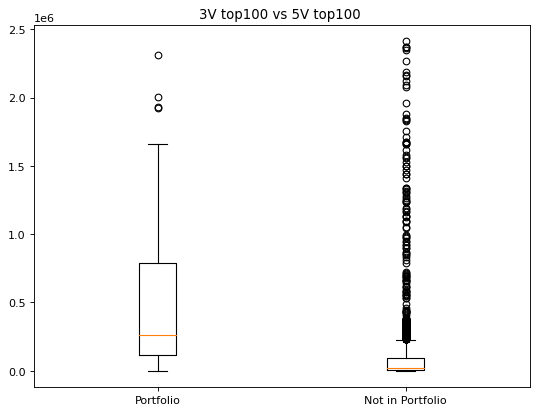

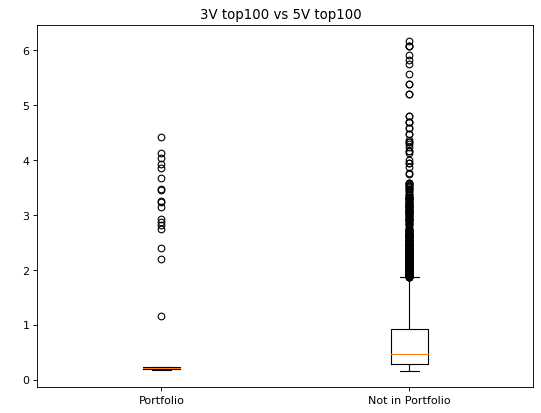

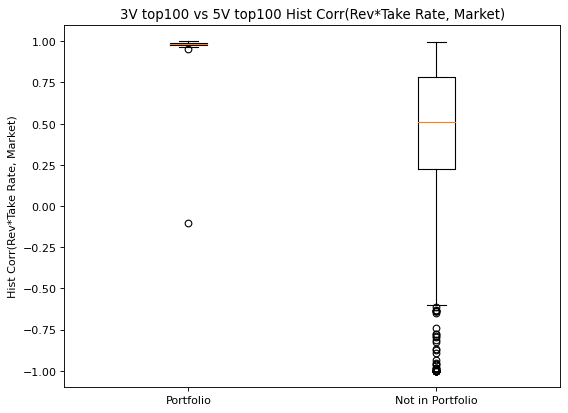

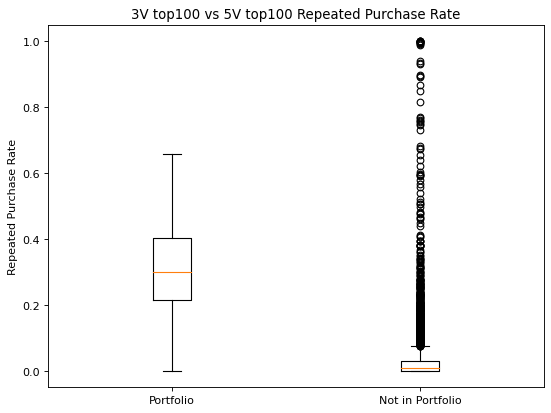

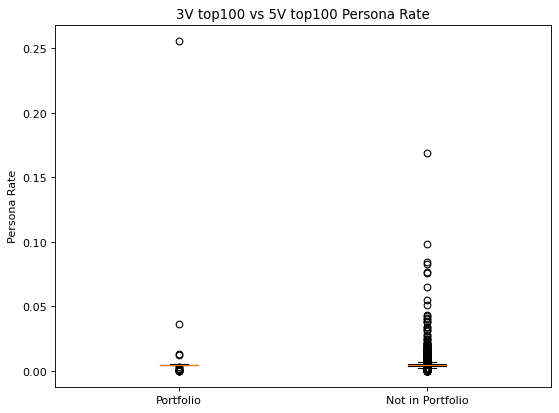

In [27]:
lists = [[five_vars_top_100_variables, five_var_complementary_variables]]
title1 = ['3V top100 vs 5V top100', "top100: 3n5' vs 5n3' vs n", "Merchants in Portfolio vs Merchants not in Portfolio"]
vars_of_interest = ['mean', 'standardised stdev', 'corr', 'repeated_purchase_rate', 'persona_score']
title2 = ['', ' ', 'Hist Corr(Rev*Take Rate, Market)', 'Repeated Purchase Rate', 'Persona Rate']
tags = [["Portfolio", "Not in Portfolio"]]

for i in range(len(lists)):
    for j in range(len(vars_of_interest)):
        draw_plot_ones(lists[i], vars_of_interest[j], title1[i], title2[j], tags[i])

# Hist

In [28]:
def draw_plot_twos(lists, var_of_interest, title1, title2):
    
    sns.set(rc={'figure.figsize':(10,10)})
    sns.set_context("paper", font_scale=3)

    fig, axes = plt.subplots(nrows=len(lists), ncols=1)
    #fig.tight_layout()
    
    x_max = max([list[var_of_interest].max() for list in lists])

    for i in range(len(lists)):
        sns.histplot(lists[i][var_of_interest], kde=True, ax = axes[i])
        
        axes[i].set_xlim(0,x_max)
        axes[i].set(xlabel=None)
        
    #plt.suptitle(f"{title1} {title2}", y=0.9)
    plt.xlabel(title2)
    
    plt.savefig(f'../plots/Histogram_{title1} {title2}.png')

    plt.show()


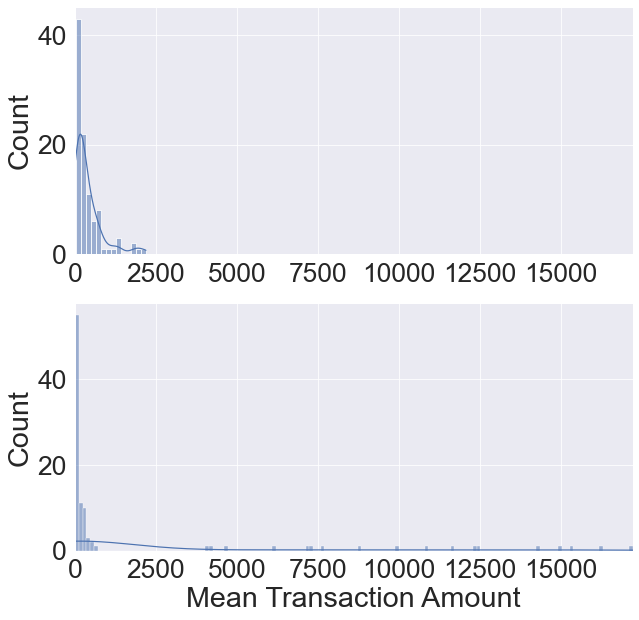

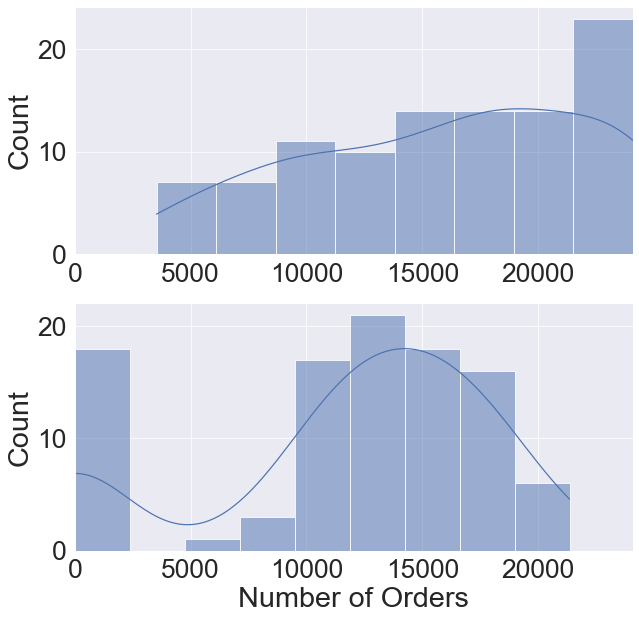

In [29]:
lists = [[three_vars_top_100_raw, five_vars_top_100_raw]]
title1 = ['3V top100 vs 5V top100']
vars_of_interest = ['mean transact amount', 'number of distinct customers']
title2 = ['Mean Transaction Amount', 'Number of Orders']

for i in range(len(lists)):
    for j in range(len(vars_of_interest)):
        draw_plot_twos(lists[i], vars_of_interest[j], title1[i], title2[j])

# Pie Chart

In [30]:
cluster_tally = five_vars_top_100_clusters['label'].value_counts()
cluster_tally

1    76
0    18
2     6
Name: label, dtype: int64

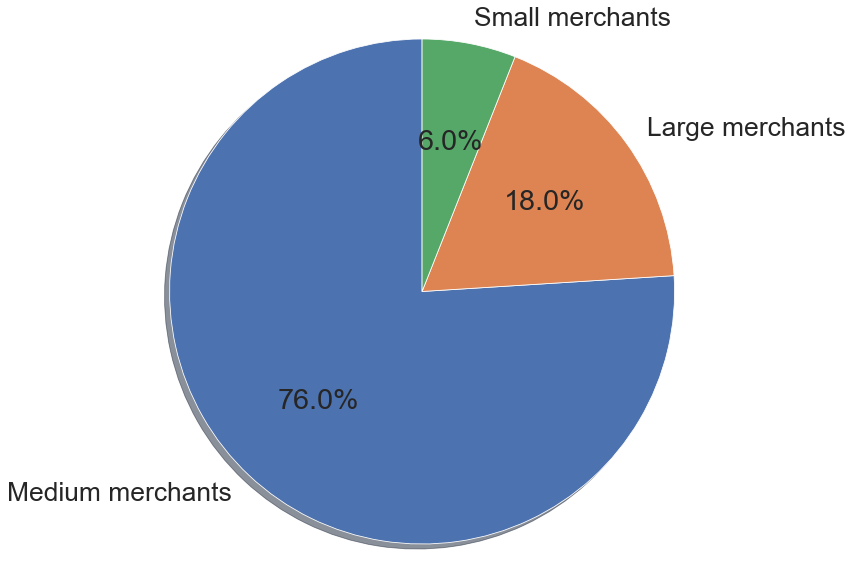

In [41]:

lables = ['Medium merchants', 'Large merchants',  'Small merchants']

fig1, ax1 = plt.subplots()
ax1.pie(cluster_tally, labels=lables, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('../plots/final 100 pie chart.png')
plt.show()

# Top 100 company names list export

In [32]:
final_10_cluster0 = pd.read_csv('../data/curated/final_model/output/final_10_cluster0.csv')

final_10_cluster1 = pd.read_csv('../data/curated/final_model/output/final_10_cluster1.csv')

final_10_cluster2 = pd.read_csv('../data/curated/final_model/output/final_10_cluster2.csv')

In [33]:
# import merchant information
merchant_info = pd.read_parquet('../data/tables/tbl_merchants.parquet')
merchant_info

,name,tags
merchant_abn,,
10023283211,Felis Limited,"((furniture, home furnishings and equipment sh..."
10142254217,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a..."
10165489824,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]..."
10187291046,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]..."
10192359162,Enim Condimentum PC,"([music shops - musical instruments, pianos, a..."
...,...,...
99938978285,Elit Dictum Eu Ltd,"[(opticians, optical goods, and eyeglasses), (..."
99974311662,Mollis LLP,"((books, periodicals, and newspapers), (b), (t..."
99976658299,Sociosqu Corp.,"((shoe shops), (a), (take rate: 6.57))"


In [34]:
# run through different lists to get data
five_vars_top_100_info = pd.DataFrame({'merchant_abn': five_var_top_100}).merge(merchant_info, on = 'merchant_abn', how='left')

In [35]:
# get ranking
five_vars_top_100_info['ranking'] = five_vars_top_100_info.index + 1
five_vars_top_100_info.to_csv('../data/curated/final_model/output/five_var_top_100_info.csv', index=False)
five_vars_top_100_info

,merchant_abn,name,tags,ranking
0,57564805948,NaN,NaN,1
1,31400548982,Non Egestas PC,"((art dealers and galleries), (b), (take rate:...",2
2,49465266764,NaN,NaN,3
3,62789659343,NaN,NaN,4
4,99801770627,Cras Convallis Ltd,"((antique shops - sales, repairs, and restorat...",5
...,...,...,...,...
95,41944909975,Et Nunc Consulting,"([books, periodicals, and newspapers], [e], [t...",96
96,67794222692,Nunc Ut Inc.,"((digital goods: books, movies, music), (c), (...",97
97,26445720989,Donec Limited,"[[opticians, optical goods, and eyeglasses], [...",98
98,52959528548,Libero Et Limited,"[[furniture, home furnishings and equIpment sh...",99


In [36]:
# get list of null companies
null_companies_ranking = five_vars_top_100_info[five_vars_top_100_info['name'].isna()][['merchant_abn', 'ranking']]
null_companies_ranking.to_csv('../data/curated/final_model/output/null_companeis_ranking.csv', index=False)
null_companies_ranking

,merchant_abn,ranking
0,57564805948,1
2,49465266764,3
3,62789659343,4
8,29215623643,9
12,98671274602,13
22,20562405782,23
71,29566626791,72
75,74648589246,76
79,75342681786,80
82,33604812025,83


In [37]:
len(null_companies_ranking)

11

In [38]:
# cluster 0 final 10
clust_0_top_10_withInfo = five_vars_top_100_info.merge(final_10_cluster0, how='right', on='merchant_abn')[['merchant_abn', 'name', 'tags','ranking']]
clust_0_top_10_withInfo.to_csv('../data/curated/final_model/output/clust_0_top_10_withInfo.csv', index=False)
clust_0_top_10_withInfo

,merchant_abn,name,tags,ranking
0,57564805948,NaN,NaN,1
1,31400548982,Non Egestas PC,"((art dealers and galleries), (b), (take rate:...",2
2,49465266764,NaN,NaN,3
3,62789659343,NaN,NaN,4
4,99801770627,Cras Convallis Ltd,"((antique shops - sales, repairs, and restorat...",5
5,10881038707,Sed Facilisis Vitae Incorporated,"((jewelry, watch, clock, and silverware shops)...",6
6,49514806178,Hendrerit Id Ante Corp.,"([jewelry, watch, clock, and silverware shops]...",7
7,48549026640,Vulputate Risus A Corporation,"([antique shops - sales, repairs, and restorat...",8
8,29215623643,NaN,NaN,9
9,81548651453,Mauris Blandit Limited,"([jEWelry, watch, clock, and silverware shops]...",10


In [39]:
# cluster 1 final 10
clust_1_top_10_withInfo = five_vars_top_100_info.merge(final_10_cluster1, how='right', on='merchant_abn')[['merchant_abn', 'name', 'tags','ranking']]
clust_1_top_10_withInfo.to_csv('../data/curated/final_model/output/clust_1_top_10_withInfo.csv', index=False)
clust_1_top_10_withInfo

,merchant_abn,name,tags,ranking
0,89640578182,Magnis Foundation,"[[tent and awning shops], [a], [take rate: 6.22]]",11
1,37459245212,Aliquet Phasellus Consulting,"[[computers, computer peripheral equipment, an...",14
2,50866797623,Cum Sociis Natoque Incorporated,"[(gift, card, novelty, and souvenir shops), (c...",18
3,88547577701,Enim Etiam Industries,"([opticiaNs, optical goods, and eyeglasses], [...",20
4,30122382323,Ipsum Company,"([watch, clock, and jewelry repair shops], [b]...",21
5,61447419161,Mollis Dui In LLP,"([gift, card, novelty, and souvenir shops], [c...",22
6,91720867026,Eget Mollis LLC,"((watch, clock, and jewelry repair shops), (a)...",26
7,21359184622,Sit Amet PC,"((motor vehicle supplies and new parts), (b), ...",27
8,31585975447,Dolor Dapibus Gravida Associates,"([digital goods: books, movies, music], [b], [...",28
9,96880556465,At Lacus Quisque Institute,"([gifT, card, novelty, and souvenir shops], [a...",29


In [40]:
# cluster 2 final 10
clust_2_top_10_withInfo = five_vars_top_100_info.merge(final_10_cluster2, how='right', on='merchant_abn')[['merchant_abn', 'name', 'tags','ranking']]
clust_2_top_10_withInfo.to_csv('../data/curated/final_model/output/clust_2_top_10_withInfo.csv', index=False)
clust_2_top_10_withInfo

,merchant_abn,name,tags,ranking
0,20562405782,NaN,NaN,23.0
1,29566626791,NaN,NaN,72.0
2,74648589246,NaN,NaN,76.0
3,75342681786,NaN,NaN,80.0
4,33604812025,NaN,NaN,83.0
5,79953723663,NaN,NaN,94.0
6,99904689266,NaN,NaN,NaN
7,67202032418,NaN,NaN,NaN
8,67330176930,NaN,NaN,NaN
9,45899477665,NaN,NaN,NaN
